In [19]:
import numpy
import matplotlib.pyplot as plt
import pandas as pd
import math
from datetime import datetime
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error


# D:\DevDoc\ML&AI Book\machinelearningmastery-code\deep_learning_with_python_code\25_lstm_simple.py

In [20]:
ab_path='../data/SPY-Daily-Y09-Now.csv'

start_date='2016-01-01'
end_date='2022-12-31'

prediction_col='Price'
look_back = 22
train_ratio= 0.8

# Default setting   reshape_way=1 isMultiLayter=True/False is_stateFul=False
reshape_way=1 # 1 is window method and 2  is step time

isMultiLayter=False

is_stateFul=False  # need reshape_way 2 (step time)




['Ticker', 'Date', 'Price', 'EMA1', 'EMA2', 'EMA3', 'MACD', 'SIGNAL', 'RSI', 'RSI-MA']
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1743 entries, 2016-01-04 to 2022-12-02
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Price   1743 non-null   float64
dtypes: float64(1)
memory usage: 27.2 KB
None
             Price
Date              
2022-11-28  395.91
2022-11-29  395.23
2022-11-30  407.68
2022-12-01  407.38
2022-12-02  406.91


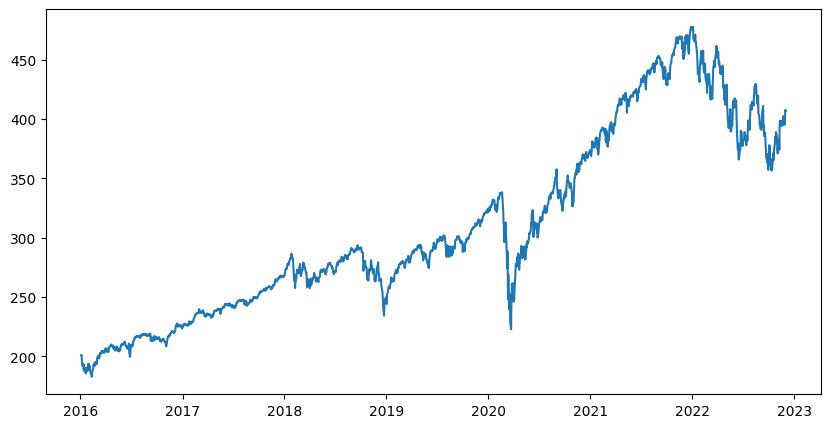

In [21]:
dataset=pd.read_csv(f'{ab_path}',parse_dates=['Date/Time'],dayfirst=True)
dataset.rename(columns={'Date/Time':'Date'},inplace=True)
allCols=list(dataset.columns)
print(allCols)

dataset['Date']=dataset['Date'].apply( lambda  dx :  datetime(dx.year,dx.month,dx.day ))
dataset.set_index('Date',inplace=True)
dataset=dataset.loc[start_date:end_date,:]
dataset=dataset[[prediction_col]]
print(dataset.info())
print(dataset.tail())

# plot baseline and predictions
plt.figure(figsize=(10,5))
plt.plot(dataset)
plt.show()

In [22]:
print("normalize the dataset  and # split into train and test sets")
# take consideration into decide whether to split before  or after scaling
# normalize the dataset


scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)


train_size =  math.ceil((len(dataset) * train_ratio))


test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]


print(train.shape,test.shape)
print(train[:3])
print(test[:3])

normalize the dataset  and # split into train and test sets
(1395, 1) (348, 1)
[[0.06159064]
 [0.06274377]
 [0.05412922]]
[[0.84178396]
 [0.85362048]
 [0.8567068 ]]


In [24]:
print("create dataset to time series training  reshape into X=t and Y=t+1")
def create_dataset(dataset, look_back=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return numpy.array(dataX), numpy.array(dataY)


trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)
print(trainX.shape,trainY.shape)
print(testX.shape,testY.shape)



create dataset to time series training  reshape into X=t and Y=t+1
(1372, 22) (1372,)
(325, 22) (325,)


In [25]:


if reshape_way==1 and is_stateFul==False:

    print("Window method and no stateFul, reshaped input to be [samples, time steps, features] (General Way)")
    trainX = numpy.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
    testX = numpy.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

elif reshape_way==2:
    print("time Step method, reshaped input to be [samples, time steps, features]")
    trainX = numpy.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
    testX = numpy.reshape(testX, (testX.shape[0], testX.shape[1], 1))
else:
    raise Exception("Not meet reshape and stateful condition")
      
print(trainX.shape,trainY.shape)
print(testX.shape,testY.shape)
print("Train Data")
print(trainX[:2])
print("Test Data")
print(trainY[:2])


Window method and no stateFul, reshaped input to be [samples, time steps, features] (General Way)
(1372, 1, 22) (1372,)
(325, 1, 22) (325,)
Train Data
[[[0.06159064 0.06274377 0.05412922 0.0379515  0.03072749 0.03137188
   0.03662879 0.02024758 0.0307614  0.0167882  0.01763609 0.00946244
   0.01298966 0.02597931 0.01621163 0.02489401 0.01787349 0.02119722
   0.03683229 0.03659488 0.02475835 0.02862472]]

 [[0.06274377 0.05412922 0.0379515  0.03072749 0.03137188 0.03662879
   0.02024758 0.0307614  0.0167882  0.01763609 0.00946244 0.01298966
   0.02597931 0.01621163 0.02489401 0.01787349 0.02119722 0.03683229
   0.03659488 0.02475835 0.02862472 0.02964219]]]
Test Data
[0.02964219 0.01726302]


In [26]:
print("create and fit the LSTM network")
numpy.random.seed(7)

n_neurons = look_back
#n_neurons = 4
n_epochs=100

n_batch_size=32


create and fit the LSTM network


In [27]:


model = Sequential()


if isMultiLayter==False:
    if is_stateFul==False:
     model.add(LSTM(n_neurons,input_shape=(trainX.shape[1],trainX.shape[2])))
    else:  
     n_batch_size=1   
     model.add(LSTM(n_neurons, batch_input_shape=(n_batch_size, look_back, 1), stateful=True))

else:
    if is_stateFul==False:
     model.add(LSTM(n_neurons,input_shape=(trainX.shape[1],trainX.shape[2]),return_sequences=True))
     model.add(LSTM(n_neurons, return_sequences=False))
    else:
     n_batch_size=1   
     model.add(LSTM(n_neurons, batch_input_shape=(n_batch_size, look_back, 1), stateful=True, return_sequences=True))
     model.add(LSTM(n_neurons, batch_input_shape=(n_batch_size, look_back, 1), stateful=True))

 

model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')

print(f"input_shape to lstm=({trainX.shape[1]}, {trainX.shape[2]})")
print(f"isMultiLayter={isMultiLayter} and is_stateFul={is_stateFul}")
print(f"n_epochs={n_epochs} on n_batch_size={n_batch_size}")

input_shape to lstm=(1, 22)
isMultiLayter=False and is_stateFul=False
n_epochs=100 on n_batch_size=32


Epoch 1/100
43/43 - 14s - loss: 0.0062 - val_loss: 0.0030 - 14s/epoch - 331ms/step
Epoch 2/100
43/43 - 0s - loss: 0.0023 - val_loss: 0.0036 - 223ms/epoch - 5ms/step
Epoch 3/100
43/43 - 0s - loss: 9.8821e-04 - val_loss: 0.0026 - 256ms/epoch - 6ms/step
Epoch 4/100
43/43 - 0s - loss: 7.4863e-04 - val_loss: 0.0023 - 278ms/epoch - 6ms/step
Epoch 5/100
43/43 - 0s - loss: 7.1777e-04 - val_loss: 0.0022 - 266ms/epoch - 6ms/step
Epoch 6/100
43/43 - 0s - loss: 6.7899e-04 - val_loss: 0.0021 - 267ms/epoch - 6ms/step
Epoch 7/100
43/43 - 0s - loss: 6.4809e-04 - val_loss: 0.0020 - 255ms/epoch - 6ms/step
Epoch 8/100
43/43 - 0s - loss: 6.1603e-04 - val_loss: 0.0018 - 231ms/epoch - 5ms/step
Epoch 9/100
43/43 - 0s - loss: 5.8531e-04 - val_loss: 0.0017 - 257ms/epoch - 6ms/step
Epoch 10/100
43/43 - 0s - loss: 5.5527e-04 - val_loss: 0.0016 - 236ms/epoch - 5ms/step
Epoch 11/100
43/43 - 0s - loss: 5.2634e-04 - val_loss: 0.0015 - 245ms/epoch - 6ms/step
Epoch 12/100
43/43 - 0s - loss: 4.9864e-04 - val_loss: 0.00

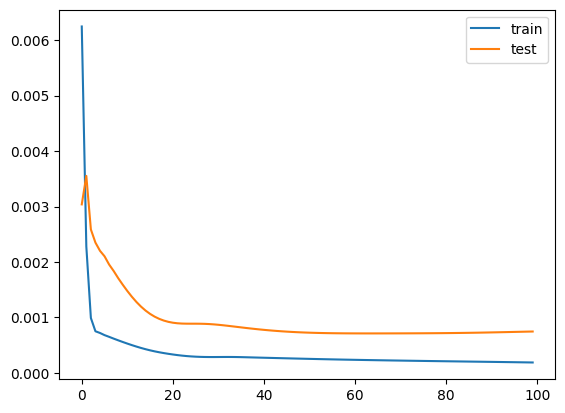

In [28]:
#model.fit(trainX, trainY, nb_epoch=100, batch_size=1, verbose=2)
if is_stateFul==False:
    history = model.fit(trainX, trainY, epochs=n_epochs, batch_size=n_batch_size, validation_data=(testX, testY), verbose=2, shuffle=False)
    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='test')
    plt.legend()
    plt.show()
else:
    for i in range(0,n_epochs):
        model.fit(trainX, trainY, epochs=1, batch_size=1, verbose=2, shuffle=False)
        model.reset_states()


In [29]:

if is_stateFul==False:
    print("make predictions")
    trainPredict = model.predict(trainX)
    testPredict = model.predict(testX)

else:
    print("make predictions  by stateFul")
    trainPredict = model.predict(trainX, batch_size=n_batch_size)
    model.reset_states()
    testPredict = model.predict(testX, batch_size=n_batch_size)



print(trainPredict.shape ,testPredict.shape)
print(testX[:1])
print(testPredict[:1])


make predictions
11/11 [==============================] - 0s 2ms/step
(1372, 1) (325, 1)
[[[0.84178396 0.85362048 0.8567068  0.87190097 0.87556385 0.86874682
   0.86813634 0.87430897 0.86705104 0.86393081 0.87600475 0.86864507
   0.8780736  0.88054943 0.87932847 0.88119383 0.88492454 0.88943531
   0.89218247 0.8957436  0.88580634 0.86932338]]]
[[0.8914619]]


In [30]:
print("invert predictions Y")
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])


invert predictions Y


In [31]:
print(testPredict.shape)
print(testPredict[:1])

print(testY.shape)
print(testY[:1])


(325, 1)
[[445.70752]]
(1, 325)
[[439.86 443.36 447.26 447.97 448.91 446.26 450.25 452.23 451.56 451.8
  453.19 453.08 451.46 450.91 448.98 445.44 446.58 444.17 447.88 447.17
  441.4  434.04 433.63 437.86 443.18 443.91 442.64 433.72 434.45 429.14
  434.24 428.64 433.1  434.9  438.66 437.86 434.69 433.62 435.18 442.5
  445.87 447.19 450.64 452.41 453.59 453.12 455.55 455.96 453.94 458.32
  459.25 460.04 461.9  464.72 466.91 468.53 468.93 467.38 463.62 463.77
  467.27 467.43 469.28 468.14 469.73 468.89 467.57 468.19 469.44 458.97
  464.6  455.56 450.5  457.4  453.42 458.79 468.28 469.52 466.35 470.74
  466.57 463.36 470.6  466.45 459.87 454.98 463.06 467.69 470.6  477.26
  476.87 477.48 476.16 474.96 477.71 477.55 468.38 467.94 466.09 465.51
  469.75 471.02 464.53 464.72 456.49 451.75 446.75 437.98 439.84 434.47
  433.38 431.24 441.95 449.91 452.95 457.35 446.6  448.7  447.26 450.94
  457.54 449.32 440.46 439.02 446.1  446.6  437.06 434.23 429.57 421.95
  428.3  437.75 436.63 429.98 437.

In [32]:
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 5.56 RMSE
Test Score: 8.04 RMSE


In [33]:
# shift train predictions for plotting
trainPredictPlot = numpy.empty_like(dataset)
trainPredictPlot[:, :] = numpy.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = numpy.empty_like(dataset)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict

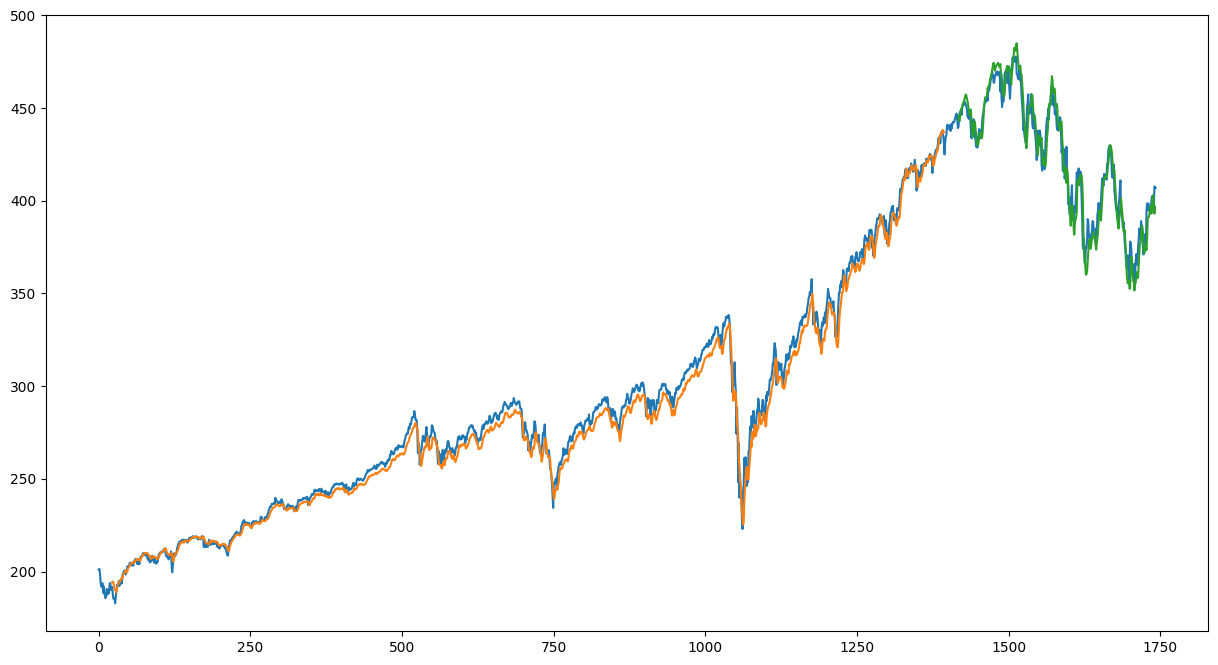

In [34]:
# plot baseline and predictions
plt.figure(figsize=(15,8))
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()